## Other ideas
https://www.reddit.com/r/MachineLearning/comments/1958jbm/d_good_ml_eng_question_banks_for_interviews/ 

- beam search, attention, dpo,etc
- have them code a simple training loop, then modify the loop to use gradient accumulation
- demonstrate monte carlo integration, and then use it to approximate pi
- top-k sampling/nucleus sampling function for GPT in numpy;
- write the transformer layer with PyTorch;
- debug this distributed numpy NN implemented;
- write a data processing pipleline with pandas/numpy;
- implement LR with numpy; 
- naive bayes
-  I have been asked to code simple image classification, sequence to sequence model.


https://github.com/alirezadir/Machine-Learning-Interviews/blob/main/src/MLC/ml-coding.md 

Linear regression (code) ✅

Logistic regression (code) ✅

K-means clustering (code) ✅

K-nearest neighbors (code 1 - code 2) ✅

Decision trees (code) ✅

Linear SVM (code)

Neural networks
Perceptron (code)
FeedForward NN (code)
Softmax (code)
Convolution (code)
CNN
RNN

### Reference Slides

Reference: https://web.stanford.edu/class/cme250/files/cme250_lecture2.pdf

#### Closed Form

- Let X be an N x M matrix containing our feature values 
- There is a unique least squares solution to the equation Xb = y iff rank(X) = M
- To get this least squares solution we want to project Xb onto the col space of X s.t. the residuals are orthogonal (to minimize the 2 norm)
- Namely, $X^Tr = X^T(y - Xb) = 0$
- This implies that $X^Ty = X^TXb$
- Which implies that $b = (X^TX)^{-1}X^Ty$

#### Mini-batch SGD

- For large datasets, computing $(X^TX)^{-1}$ can be too computationally expensive, so we can use mini-batch SGD

- ... 

In [99]:
import pdb

import numpy as np
import matplotlib.pyplot as plt

In [251]:
def gen_data(n, m=3, b=10, rand_coef=3):
    """
    Generates synthetic data to test linear regression
    
    mx + b + noise
    """
    x = np.arange(n)
    y = np.array([xx * m + b + np.random.rand()*rand_coef for xx in x])
    return x, y


class LinearRegression(object):

    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.b = None

    def fit(self):
        x = np.concatenate([np.ones_like(self.x), self.x], axis=1)
        pseudo_inv = np.linalg.inv(x.T @ x)
        self.b = pseudo_inv @ x.T @ self.y 
        self.b = self.b.flatten()

    def __call__(self, x_input):
        """
        This assumes that input data is 2d
        """
        y_pred = [xx*self.b[1] + self.b[0] for xx in x_input]
        return y_pred


class Loader(object):

    def __init__(self, x, y, batch_size):
        self.x = x
        self.y = y
        assert x.shape[0] % batch_size == 0
        self.n_batches = x.shape[0] // batch_size
        self._reset()

    def _reset(self):
        self.iter = 0
        self.idxs = np.arange(self.x.shape[0])        
        np.random.shuffle(self.idxs)
        self.idxs = np.array_split(self.idxs, self.n_batches)
    
    def __iter__(self):
        self.iter = 0
        return self

    def __next__(self):
        if self.iter >= self.n_batches:
            self.iter = 0
            self._reset()
        batch_idxs = self.idxs[self.iter]
        self.iter += 1
        return {"x": self.x[batch_idxs], "y": self.y[batch_idxs]}


class ScalableLinearRegression(LinearRegression):

    def __init__(self, d_feats, lr, loader, n_iters, reg_coef=0.1):
        super().__init__(x=None, y=None)
        self.lr = lr
        self.loader = loader
        self.n_iters = n_iters
        self.b = np.zeros(d_feats) #np.random.rand(d_feats)
        self.reg_coef = reg_coef
    
    def fit(self):
        for i in range(self.n_iters):
            batch = next(self.loader)
            x, y = batch["x"], batch["y"]
            y_pred = x @ self.b
            # TODO: does the order here matter
            residual = y_pred - y
            loss = np.mean((residual)**2, axis=0)
            #grad = (2 * x.T) @ residual
            # TODO: why isn't this a negative 2 in front
            #grad = 2 * np.dot(x.T, (y_pred - y)) 
            grad = (2 / x.shape[0]) * x.T @ (y_pred - y) + 2*self.reg_coef*self.b
            print("grad shape:", grad.shape)
            self.b = self.b - self.lr * grad
            print("loss:", loss, "iter:", i)



In [252]:
x_gen_big, y_gen_big = gen_data(4*100)
# put x into the expected shape
x_gen_big = x_gen_big.reshape(-1, 1)
y_gen_big = y_gen_big.reshape(-1, 1)

loader = Loader(
    x=np.concatenate([np.ones(x_gen_big.shape[0]).reshape(-1, 1), x_gen_big], axis=1),
    y=y_gen_big.flatten(),
    batch_size=4,
)

In [255]:
slr = ScalableLinearRegression(d_feats=2, lr=1e-6, loader=loader, n_iters=100)

In [256]:
slr.fit()

grad shape: (2,)
loss: 259933.22633682378 iter: 0
grad shape: (2,)
loss: 561181.4866047694 iter: 1
grad shape: (2,)
loss: 486163.8480328893 iter: 2
grad shape: (2,)
loss: 163771.93025886762 iter: 3
grad shape: (2,)
loss: 50759.44629959676 iter: 4
grad shape: (2,)
loss: 263019.9663561305 iter: 5
grad shape: (2,)
loss: 51728.561601226145 iter: 6
grad shape: (2,)
loss: 113893.30667655187 iter: 7
grad shape: (2,)
loss: 116908.78804032164 iter: 8
grad shape: (2,)
loss: 31127.63198204834 iter: 9
grad shape: (2,)
loss: 122884.95984731516 iter: 10
grad shape: (2,)
loss: 37092.752096500015 iter: 11
grad shape: (2,)
loss: 61525.76675487662 iter: 12
grad shape: (2,)
loss: 24993.9421870362 iter: 13
grad shape: (2,)
loss: 30307.173076233477 iter: 14
grad shape: (2,)
loss: 21204.632191224457 iter: 15
grad shape: (2,)
loss: 3911.4138329761095 iter: 16
grad shape: (2,)
loss: 23281.535665668533 iter: 17
grad shape: (2,)
loss: 10159.310346236187 iter: 18
grad shape: (2,)
loss: 5897.4822516591685 iter: 1

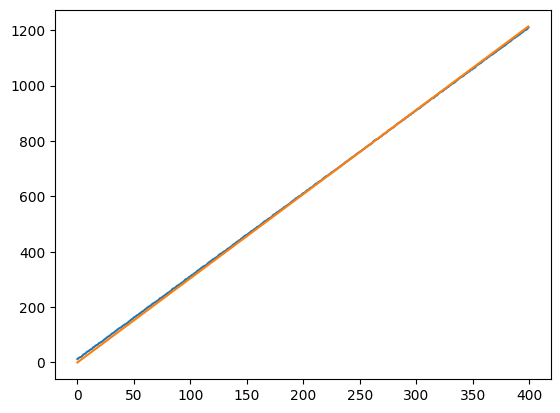

In [257]:
y_pred_big = slr(x_gen_big)

plt.plot(x_gen_big, y_gen_big, label="data")
plt.plot(x_gen_big, y_pred_big, label="preds-gd")

In [8]:
x_gen, y_gen = gen_data(10)
# put x into the expected shape
x_gen = x_gen.reshape(-1, 1)
y_gen = y_gen.reshape(-1, 1)

In [9]:
lin_reg = LinearRegression(x_gen, y_gen)
lin_reg.fit()
y_pred = lin_reg(x_gen)

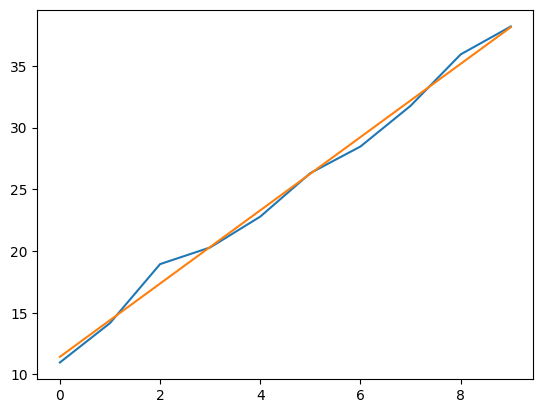

In [11]:
plt.plot(x_gen, y_gen, label="data")
plt.plot(x_gen, y_pred, label="preds")